In [1]:
from pathlib import Path
from functools import partial

from utils import load_polar

import pybem as pb
import numpy as np
import pandas as pd
import proplot as plot

Inputs

In [2]:
PATH_POLARS = Path("../polars")
file_lift = "lift.csv"
file_drag = "drag.csv"
file_propeller = PATH_POLARS / "propeller1_inches.txt"

PITCH = 32.4  # inches

In [3]:
INCH_METER = 0.0254
PITCH = INCH_METER * PITCH  # meters

In [4]:
csv_reader = partial(pd.read_csv, sep=";", index_col=None)
load_polar = partial(
    load_polar,
    path=PATH_POLARS,
    file_lift=file_lift,
    file_drag=file_drag,
    reader=csv_reader,
)

In [5]:
dimensions_df = pd.read_csv(filepath_or_buffer=file_propeller, sep=",")

# Enforce stripped columns
dimensions_df.columns = [col.strip() for col in dimensions_df.columns]
dimensions_df = dimensions_df[["radius", "chord"]]

# Convert to international units
dimensions_df = dimensions_df.mul(INCH_METER)

# Name
dimensions_df.index = ["Hub", "S1", "S2", "S3", "S4", "Tip"]

for idx, row in dimensions_df.iterrows():

    r = row["radius"]

    # Constant pitch law
    tan_theta = PITCH / (2.0 * np.pi * r) 
    theta = np.arctan(tan_theta)  # radians
    theta = np.rad2deg(theta)  # degrees

    dimensions_df.loc[idx, "theta"] = theta

dimensions_df

,radius,chord,theta
Hub,0.1016,0.06223,52.199199
S1,0.1778,0.06858,36.377590
S2,0.2540,0.06858,27.278439
S3,0.3302,0.06858,21.636400
S4,0.4064,0.06858,17.863548
Tip,0.4572,0.06858,15.985890


array([<AxesSubplot:xlabel='radius'>, <AxesSubplot:xlabel='radius'>],
      dtype=object)

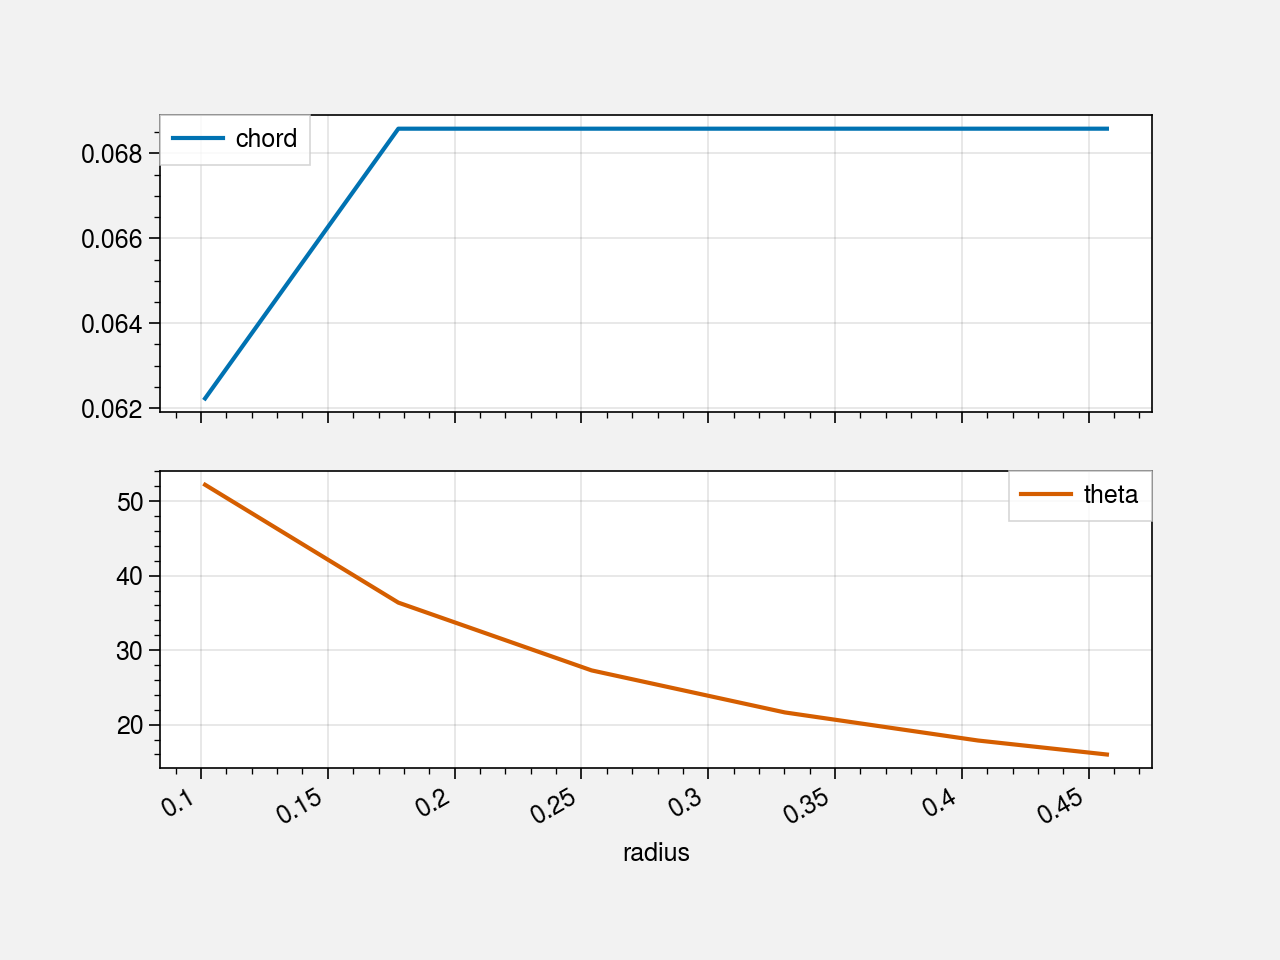

In [6]:
dimensions_df.set_index("radius").plot(subplots=True)

Create the blade by defining the sections at each stage.

In [15]:
# Define known sections
sections = [
    pb.Section(
        name="Hub",
        r=dimensions_df.loc["Hub", "radius"],
        beta=dimensions_df.loc["Hub", "theta"],
        chord=dimensions_df.loc["Hub", "chord"],
        airfoil=pb.Airfoil(
            polar_cl=load_polar(airfoil_type="765", which="cl"),
            polar_cd=load_polar(airfoil_type="765", which="cd"),
        ),
    ),
    pb.Section(
        name="S1",
        r=dimensions_df.loc["S1", "radius"],
        beta=dimensions_df.loc["S1", "theta"],
        chord=dimensions_df.loc["S1", "chord"],
        airfoil=pb.Airfoil(
            polar_cl=load_polar(airfoil_type="765", which="cl"),
            polar_cd=load_polar(airfoil_type="765", which="cd"),
        ),
    ),
    pb.Section(
        name="S2",
        r=dimensions_df.loc["S2", "radius"],
        beta=dimensions_df.loc["S2", "theta"],
        chord=dimensions_df.loc["S2", "chord"],
        airfoil=pb.Airfoil(
            polar_cl=load_polar(airfoil_type="764", which="cl"),
            polar_cd=load_polar(airfoil_type="764", which="cd"),
        ),
    ),
    pb.Section(
        name="S3",
        r=dimensions_df.loc["S3", "radius"],
        beta=dimensions_df.loc["S3", "theta"],
        chord=dimensions_df.loc["S3", "chord"],
        airfoil=pb.Airfoil(
            polar_cl=load_polar(airfoil_type="763", which="cl"),
            polar_cd=load_polar(airfoil_type="763", which="cd"),
        ),
    ),
    pb.Section(
        name="S4",
        r=dimensions_df.loc["S4", "radius"],
        beta=dimensions_df.loc["S4", "theta"],
        chord=dimensions_df.loc["S4", "chord"],
        airfoil=pb.Airfoil(
            polar_cl=load_polar(airfoil_type="762", which="cl"),
            polar_cd=load_polar(airfoil_type="762", which="cd"),
        ),
    ),
    pb.Section(
        name="Tip",
        r=dimensions_df.loc["Tip", "radius"],
        beta=dimensions_df.loc["Tip", "theta"],
        chord=dimensions_df.loc["Tip", "chord"],
        airfoil=pb.Airfoil(
            polar_cl=load_polar(airfoil_type="761", which="cl"),
            polar_cd=load_polar(airfoil_type="761", which="cd"),
        ),
    ),
]

In [23]:
# Define propeller
B = 2
propeller = pb.Propeller(B=B, sections=sections)

# Define flow conditions and BEM method

results = []
for J in np.linspace(1e-1, 1.5):

    pi = np.pi

    _lambda = J / pi

    bem = pb.BladeElementMethod(
        _lambda=_lambda, propeller=propeller, tip_loss=True, hub_loss=False
    )

    try:
        # Solve
        bem.solve()
        CT, CQ = bem.integrate_forces()
    except:
        CT = np.nan
        CQ = np.nan

    # Create experiments non-dimensionless coefficients
    results.append(
        (
            J,
            CT * (pi ** 3.0) / 4 / J ** 2.0,
            CQ * (pi ** 4.0) / 4 / J ** 2.0,
            _lambda * CT / CQ, # efficiency
        )
    )

In [24]:
results_df = (
    pd.DataFrame(results, columns=["J", "CT", "CP", "eta"])
    .dropna()
    .set_index("J")
)

In [25]:
G = 9.81

In [26]:
PATH_EXPERIMENTS = Path("../experimental_results")
path_thrust = PATH_EXPERIMENTS / 'thrust_coefficient.csv'
path_torque = PATH_EXPERIMENTS / 'torque_coefficient.csv'
path_efficiency = PATH_EXPERIMENTS / 'efficiency.csv'

In [27]:
experimental_thrust = pd.read_csv(path_thrust, sep = ';', index_col=0)
experimental_torque = pd.read_csv(path_torque, sep = ';', index_col=0)
experimental_efficiency = pd.read_csv(path_efficiency, sep = ";", index_col = 0)

experimental_thrust = experimental_thrust.sort_index().div(G)
experimental_torque = experimental_torque.sort_index().div(G)
experimental_efficiency = experimental_efficiency.sort_index()

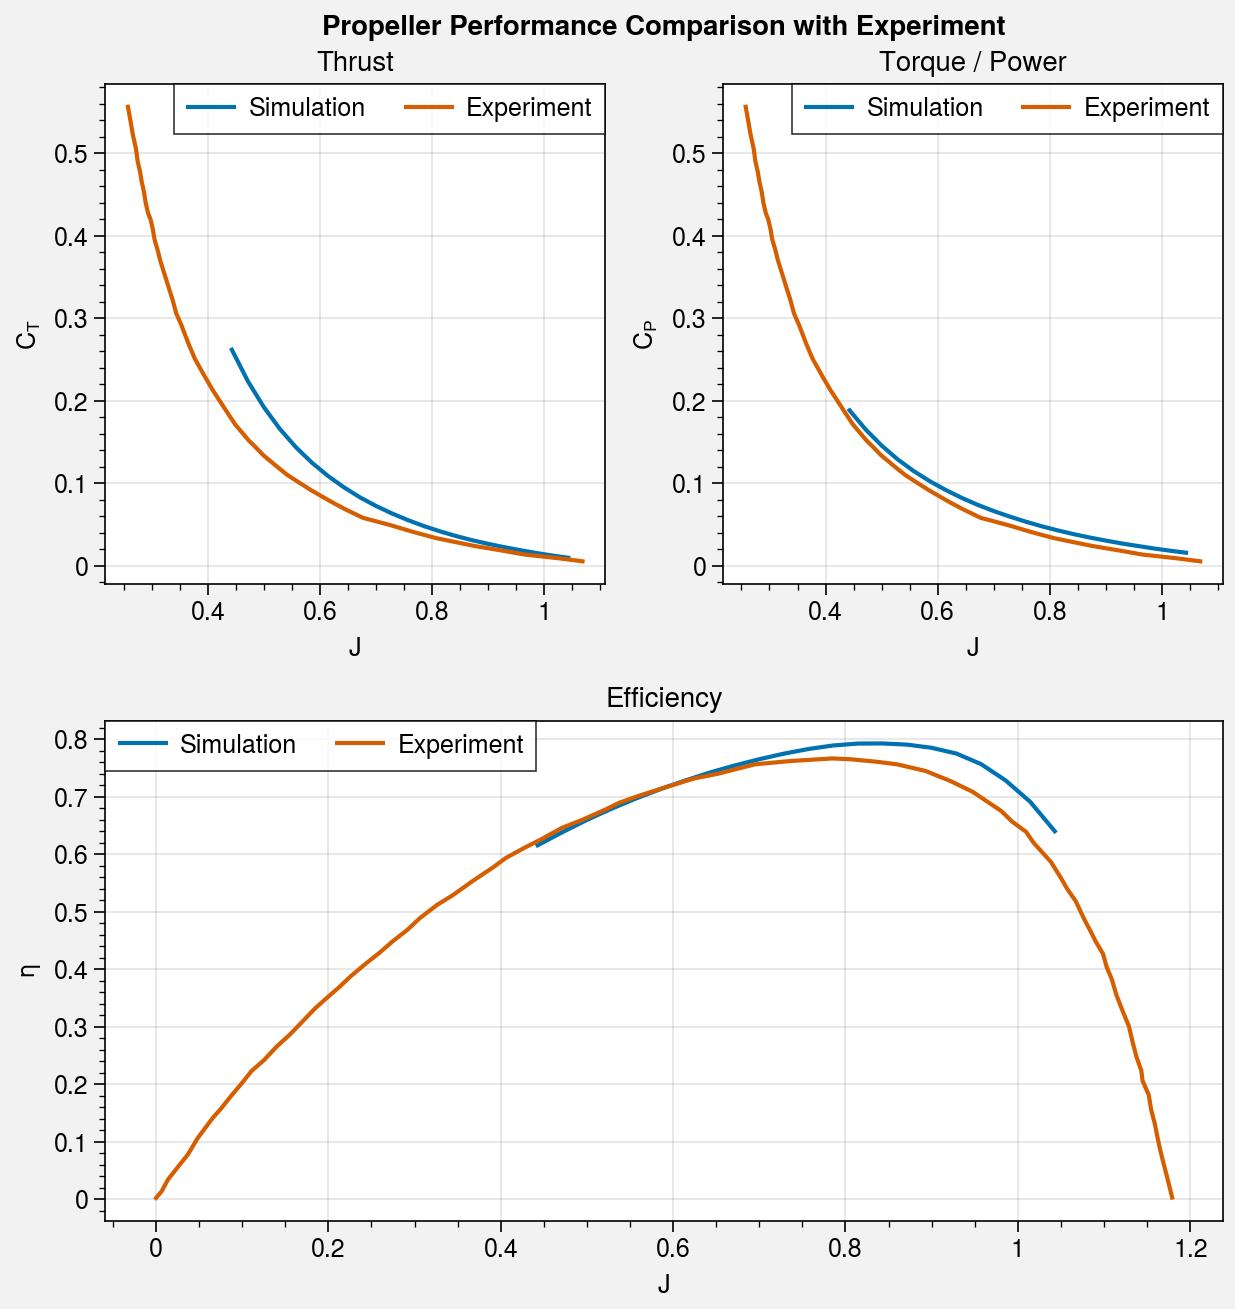

In [48]:
_array = [[1, 2], [3, 3]]
fig, axes = plot.subplots(array=_array, share=0)

############
# Thrust
############
ax = axes[0]
ax.plot(
    results_df.drop(["eta", "CP"], axis=1),
)
ax.plot(experimental_thrust)
ax.format(
    title="Thrust",
    ylabel="$C_T$",
    suptitle="Propeller Performance Comparison with Experiment",
)
ax.legend(labels=["Simulation", "Experiment"])

############
# Torque
############
ax = axes[1]
ax.plot(
    results_df.drop(["eta", "CT"], axis=1),
)
ax.plot(experimental_thrust)
ax.format(
    title="Torque / Power",
    ylabel="$C_P$",
    suptitle="Propeller Performance Comparison with Experiment",
)
ax.legend(labels=["Simulation", "Experiment"])

############
# Efficiency
############
ax = axes[-1]
ax.plot(results_df["eta"])
ax.plot(experimental_efficiency)
ax.format(title="Efficiency", ylabel="$\eta$")
ax.legend(labels=["Simulation", "Experiment"], frame = True)

fig.save("tst")


In [38]:
J = 0.6

pi = np.pi

_lambda = J / pi

bem = pb.BladeElementMethod(
    _lambda=_lambda, propeller=propeller, tip_loss=True, hub_loss=False
)

bem.solve()
CT, CQ = bem.integrate_forces()
CT = CT * (pi ** 3.0) / 4 / J ** 2.0
CQ = CQ * (pi ** 4.0) / 4 / J ** 2.0

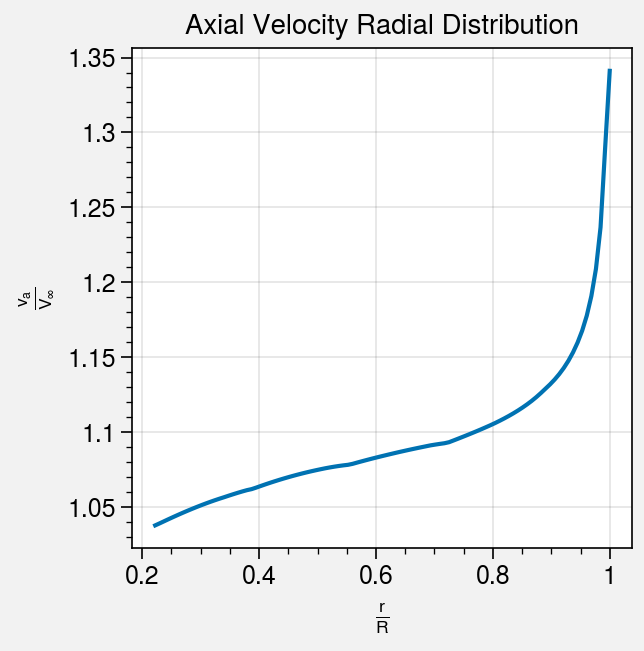

In [54]:
fig, axes = plot.subplots()
axes.plot(bem.r_dist, bem.axial_velocity_radial_distribution)
axes.format(xlabel = "$\\frac{r}{R}$",
            ylabel = "$\\frac{v_a}{V_{\infty}}$", 
            title="Axial Velocity Radial Distribution")
fig.save("loading_distribution")